In [1]:
# Gerekli kütüphaneleri içe aktaralım
import warnings
warnings.filterwarnings("ignore",category=Warning)
warnings.filterwarnings("ignore",category=FutureWarning)
warnings.filterwarnings("ignore",category=DeprecationWarning)
import logging 
logging.getLogger().setLevel(logging.CRITICAL)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import time

# GPU kullanılabilirliğini kontrol edelim
print("TensorFlow sürümü:", tf.__version__)
print("GPU kullanılabilir mi?", "Evet" if tf.config.list_physical_devices('GPU') else "Hayır")

2025-09-21 19:01:56.367040: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1758481316.586100      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1758481316.646600      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


TensorFlow sürümü: 2.18.0
GPU kullanılabilir mi? Evet


Merhaba, gerekli tüm kütüphaneleri ekleyerek başlıyoruz.

Sınıf isimleri: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
X_train shape: (14034, 150, 150, 3)
y_train shape: (14034,)
X_test shape: (3000, 150, 150, 3)
y_test shape: (3000,)
Eğitim verisi şekli: (14034, 150, 150, 3)
Test verisi şekli: (3000, 150, 150, 3)
Sınıf sayısı: 6


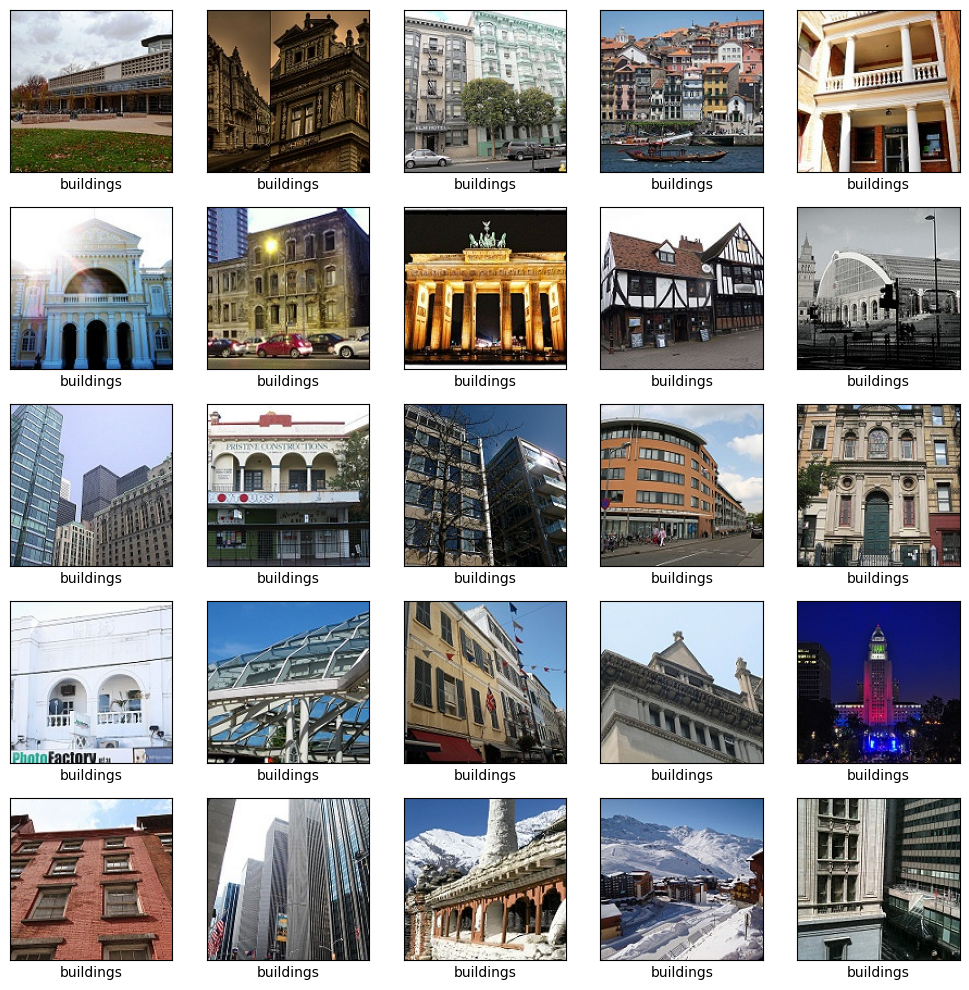

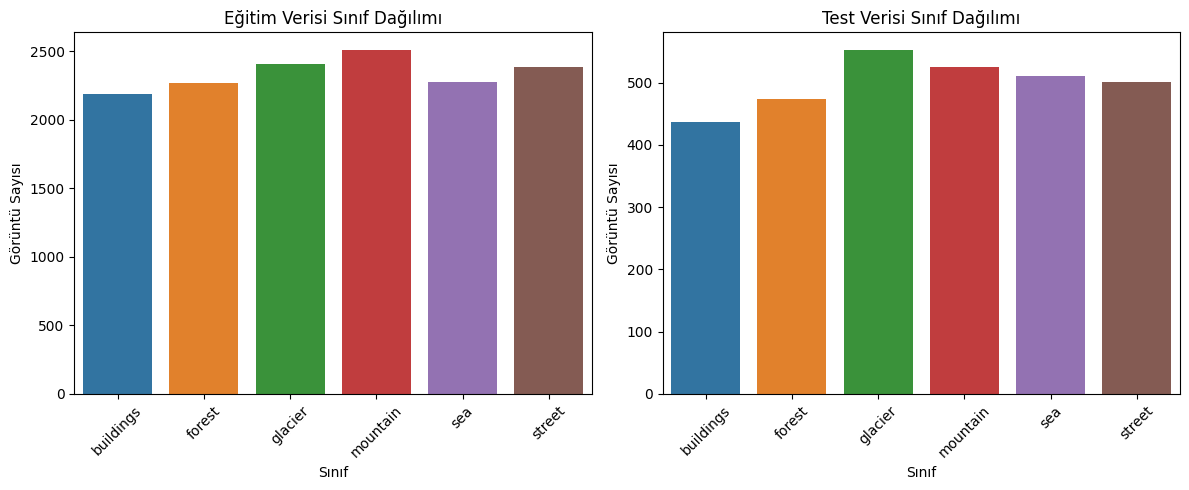

In [2]:
# Ayarlar
IMAGE_SIZE = (150, 150)
BATCH_SIZE = 64
NUM_CLASSES = 6

# Veri yollarını ayarla (Kaggle Notebook’unda klasör yolu değişebilir)
train_dir = "/kaggle/input/intel-image-classification/seg_train/seg_train"
test_dir  = "/kaggle/input/intel-image-classification/seg_test/seg_test"

# Sınıf isimleri klasör adlarından alalım (sorted ile sıralı alırız)
class_names = sorted(os.listdir(train_dir))
print("Sınıf isimleri:", class_names)

# Görüntüleri ve etiketleri yüklemek için fonksiyon
def load_data(data_dir, class_names, img_size=(150, 150)):
    images = []
    labels = []
    for idx, class_name in enumerate(class_names):
        class_path = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = load_img(img_path, target_size=img_size)
            img = img_to_array(img)
            images.append(img)
            labels.append(idx)
    return np.array(images), np.array(labels)

# Veriyi yükleyelim
X_train, y_train = load_data(train_dir, class_names)
X_test, y_test = load_data(test_dir, class_names)

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

# Veri şekillerini yazdıralım
print("Eğitim verisi şekli:", X_train.shape)
print("Test verisi şekli:", X_test.shape)
print("Sınıf sayısı:", len(class_names))

# İlk 25 görüntüyü görselleştirelim
plt.figure(figsize=(10, 10))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(X_train[i].astype('uint8'))
    plt.xlabel(class_names[y_train[i]])
plt.tight_layout()
plt.show()

# Sınıf dağılımını inceleyelim
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x=y_train)
plt.title('Eğitim Verisi Sınıf Dağılımı')
plt.xlabel('Sınıf')
plt.ylabel('Görüntü Sayısı')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)

plt.subplot(1, 2, 2)
sns.countplot(x=y_test)
plt.title('Test Verisi Sınıf Dağılımı')
plt.xlabel('Sınıf')
plt.ylabel('Görüntü Sayısı')
plt.xticks(ticks=range(len(class_names)), labels=class_names, rotation=45)

plt.tight_layout()
plt.show()

Veri Hazırlama ve Keşifsel Veri Analizi

Intel Image Classification veri seti ile çalışıyoruz.

Bu bölümde:
Eğitim ve test verileri belirlenen klasörlerden yüklendi.
Görüntüler 150x150 boyutuna getirilip sayısal verilere dönüştürüldü.
Sınıf isimleri klasör adlarından alındı.
Eğitim ve test veri boyutları kontrol edildi.
İlk 25 görüntü sınıf etiketleriyle birlikte görselleştirildi.
Eğitim ve test setlerindeki sınıf dağılımları çubuk grafiklerle analiz edildi.
Bu adımlar, veriyi tanımak ve model eğitimi için hazırlamak amacıyla yapıldı.

In [3]:
# Veriyi normalize edelim (0-255 arası değerleri 0-1 arasına dönüştürelim)
X_train = X_train.astype('float32') / 255.0
X_test = X_test.astype('float32') / 255.0

# Etiketleri one-hot encoding formatına dönüştürelim
num_classes = len(class_names) 
y_train_categorical = keras.utils.to_categorical(y_train, num_classes)
y_test_categorical = keras.utils.to_categorical(y_test, num_classes)

# Veri artırma için ImageDataGenerator kullanalım
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)
# Veri artırma işlemini eğitim verisine uygulayalım
datagen.fit(X_train)

# Normalizasyon ve one-hot encoding sonrası veri boyutlarını kontrol edelim
print("Normalize edilmiş eğitim verisi şekli:", X_train.shape)
print("One-hot encoded eğitim etiketleri şekli:", y_train_categorical.shape)

Normalize edilmiş eğitim verisi şekli: (14034, 150, 150, 3)
One-hot encoded eğitim etiketleri şekli: (14034, 6)


Bu adımda model eğitimi için gerekli veri ön işlemleri gerçekleştirilmiştir:

Normalizasyon:
Görüntü verileri 0-255 aralığından 0-1 aralığına ölçeklendirildi.

One-hot Encoding:
Sınıf etiketleri, modelin anlayabileceği şekilde one-hot vektörlerine dönüştürüldü.

Veri Artırma (Augmentation):
Eğitim verisinin çeşitliliğini artırmak için ImageDataGenerator kullanılarak döndürme, kaydırma, yakınlaştırma ve yatay çevirme gibi rastgele dönüşümler uygulandı.

Kontrol:
İşlem sonrası eğitim verisi ve etiketlerinin boyutları yazdırılarak her şeyin doğru çalıştığı doğrulandı.

In [4]:
def create_optimized_cnn_model(input_shape=(150, 150, 3), num_classes=6):
    model = keras.Sequential()

    # Block 1
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.2))

    # Block 2
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.3))

    # Block 3
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.4))
    
    # Block 4
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Dropout(0.5))

    # Flatten + Dense
    model.add(layers.Flatten())
    model.add(layers.Dense(256, activation='relu'))  # Daha yüksek boyutlu dense
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(6, activation='softmax'))

    return model

# Modeli oluşturalım
cnn_model = create_optimized_cnn_model()

# Model özetini görüntüleyelim
cnn_model.summary()

I0000 00:00:1758481412.584884      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13942 MB memory:  -> device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5
I0000 00:00:1758481412.585502      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13942 MB memory:  -> device: 1, name: Tesla T4, pci bus id: 0000:00:05.0, compute capability: 7.5


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 18, 18, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 18, 18, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 6,487,334 (24.75 MB)

 Trainable params: 6,484,902 (24.74 MB)

 Non-trainable params: 2,432 (9.50 KB)

Optimize Edilmiş CNN modelini hazırladık.

Girdi Boyutu: 150x150 RGB görüntüler
Çıkış: 6 sınıflı softmax katmanı

4 Konvolüsyon Bloğundan Oluşturduk:
Her blokta 2 adet Conv2D + ReLU, ardından BatchNormalization, MaxPooling ve Dropout katmanları kullanılmıştır.
Aşırı öğrenmeyi (overfitting) azaltmak için her blokta artan oranlarla Dropout uygulanmıştır.
Flatten sonrası 256 nöronlu yoğun (dense) katman, ardından BatchNormalization, Dropout ve softmax ile çıktı alınmıştır.
model.summary() ile mimarinin yapısı, parametre sayısı ve her katmanın çıktısı detaylı olarak incelenmiştir.

Epoch 1/50


I0000 00:00:1758481423.511436      65 service.cc:148] XLA service 0x7a6248008bc0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1758481423.512743      65 service.cc:156]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1758481423.512767      65 service.cc:156]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1758481424.433692      65 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1758481443.439188      65 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


220/220 ━━━━━━━━━━━━━━━━━━━━ 110s 370ms/step - accuracy: 0.5373 - loss: 1.3532 - val_accuracy: 0.2497 - val_loss: 3.9426 - learning_rate: 0.0010
Epoch 2/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 65s 293ms/step - accuracy: 0.7365 - loss: 0.7392 - val_accuracy: 0.6077 - val_loss: 1.3075 - learning_rate: 0.0010
Epoch 3/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 68s 306ms/step - accuracy: 0.7738 - loss: 0.6327 - val_accuracy: 0.7593 - val_loss: 0.6358 - learning_rate: 0.0010
Epoch 4/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 65s 296ms/step - accuracy: 0.8086 - loss: 0.5416 - val_accuracy: 0.7467 - val_loss: 0.6951 - learning_rate: 0.0010
Epoch 5/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 67s 303ms/step - accuracy: 0.8251 - loss: 0.4923 - val_accuracy: 0.6830 - val_loss: 0.9535 - learning_rate: 0.0010
Epoch 6/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 66s 300ms/step - accuracy: 0.8295 - loss: 0.4615 - val_accuracy: 0.7677 - val_loss: 0.6011 - learning_rate: 0.0010
Epoch 7/50
220/220 ━━━━━━━━━━━━━━━━━━━━ 66s 300ms/step - accuracy: 0.8426 - loss

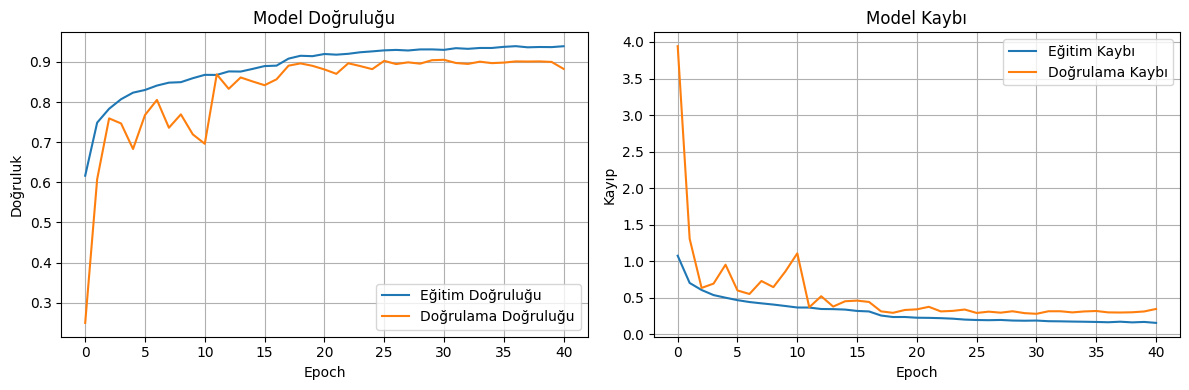

In [5]:
import time
import matplotlib.pyplot as plt
from tensorflow import keras

# Modeli derleyelim
cnn_model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

# Callback'leri tanımlayalım (erken durdurma ve öğrenme oranı ayarlama)
early_stopping = keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = keras.callbacks.ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=5,
    min_lr=0.0001
)

# Veri artırma (augmentasyon) için ImageDataGenerator (eğer daha önceden tanımlanmadıysa)
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    zoom_range=0.1
)

# Modeli eğitelim
start_time = time.time()

history = cnn_model.fit(datagen.flow(X_train, y_train_categorical, batch_size=64),
                        epochs=50,
                        validation_data=(X_test, y_test_categorical),
                        callbacks=[early_stopping, reduce_lr],
                        verbose=1)

training_time = time.time() - start_time
print(f"Eğitim süresi: {training_time:.2f} saniye")

# Eğitim ve doğrulama kaybı/doğruluğunu görselleştirelim
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Model Doğruluğu')
plt.xlabel('Epoch')
plt.ylabel('Doğruluk')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Model Kaybı')
plt.xlabel('Epoch')
plt.ylabel('Kayıp')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Model Eğitimi ve Performans Görselleştirme

Bu bölümde CNN modelimizin eğitimi gerçekleştirilmiştir. Eğitim sürecinde çeşitli stratejiler kullanılarak modelin doğruluk ve genelleme performansı optimize edilmiştir.

Eğitim Ayarları

Optimizer: Adam
Kayıp Fonksiyonu: Categorical Crossentropy
Başarı Metrikleri: Accuracy
Epoch: 50
Learning Rate ve Batch Size için aşağıdaki değerler denenerek en verimli sonuca ulaşılan değerler tercih edilerek devam edilmiştir.
Batch Size: 64 (denenen değerler: 16, 32, 64)
Learning Rate: 0.001 (denenen değerler: 0.1, 0.001, 0.0001)

Callback'ler

EarlyStopping:
Doğrulama kaybı 10 epoch boyunca iyileşmezse eğitim durdurulmuştur.
ReduceLROnPlateau:
Doğrulama kaybı sabit kalırsa öğrenme oranı azaltılmıştır.

Eğitim Sonuçlarının Görselleştirilmesi

Eğitim süresi ölçülmüş ve ekrana yazdırılmıştır.
Modelin doğruluk (accuracy) ve kayıp (loss) değerleri eğitim ve doğrulama setleri için çizilerek görselleştirilmiştir.
Bu grafikler sayesinde modelin aşırı öğrenme (overfitting) yapıp yapmadığı gözlemlenebilir.

Test Kaybı: 0.2818
Test Doğruluğu: 0.9053
94/94 ━━━━━━━━━━━━━━━━━━━━ 4s 36ms/step

Sınıflandırma Raporu:
              precision    recall  f1-score   support

   buildings       0.90      0.89      0.89       437
      forest       0.96      0.99      0.98       474
     glacier       0.88      0.87      0.87       553
    mountain       0.89      0.84      0.86       525
         sea       0.90      0.95      0.92       510
      street       0.91      0.91      0.91       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.90      0.91      0.90      3000



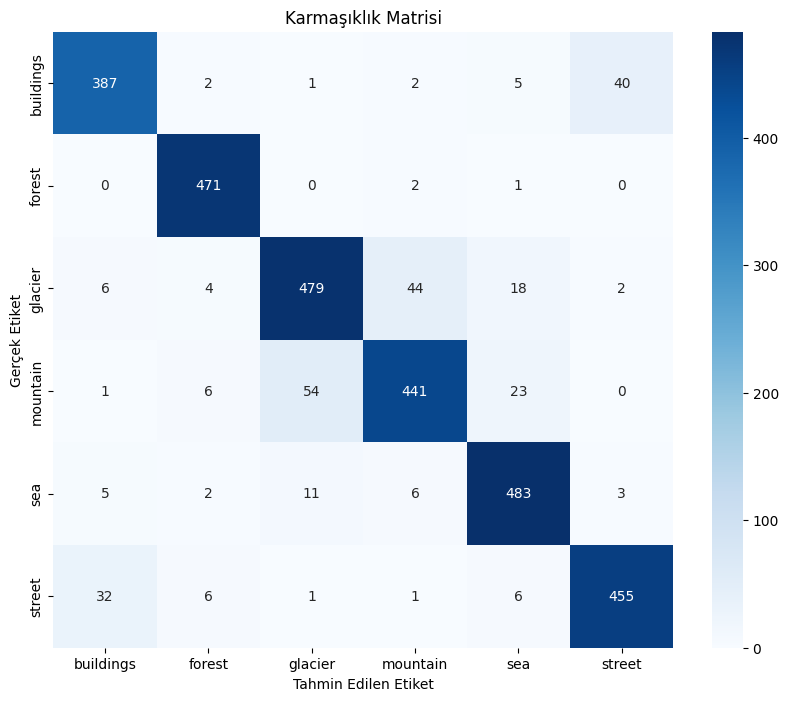

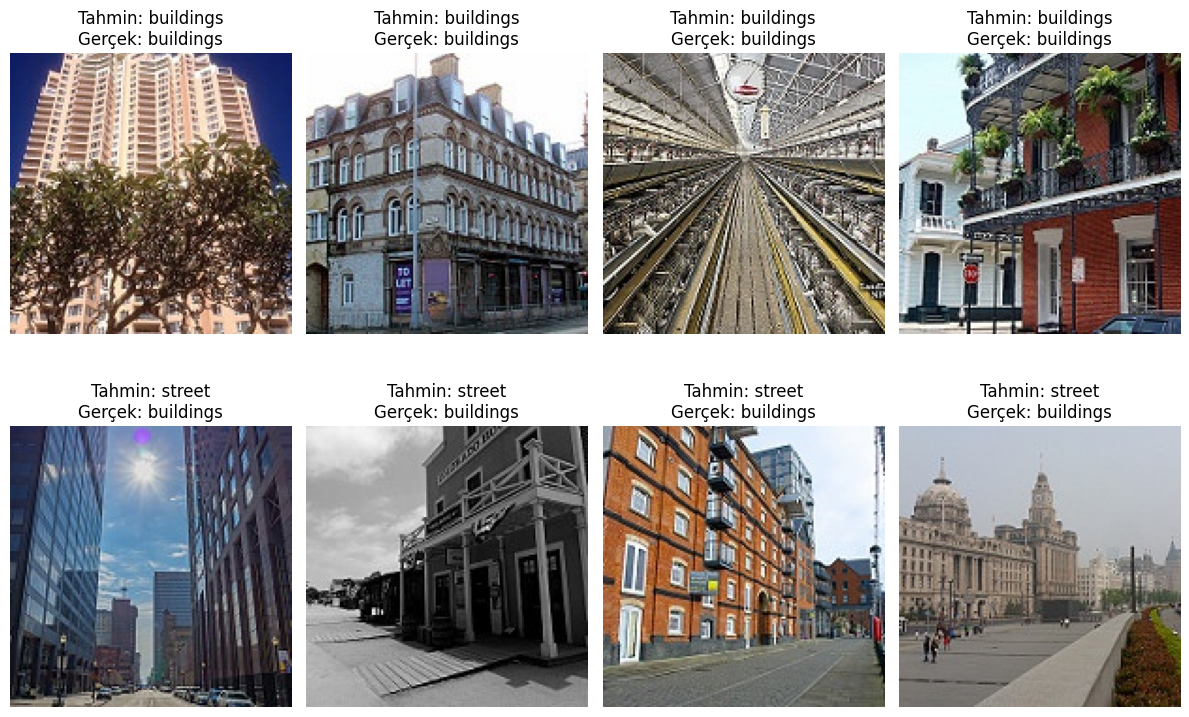

In [6]:
# Test seti üzerinde modeli değerlendirelim
test_loss, test_accuracy = cnn_model.evaluate(X_test, y_test_categorical, verbose=0)
print(f"Test Kaybı: {test_loss:.4f}")
print(f"Test Doğruluğu: {test_accuracy:.4f}")

# Tahminlerde bulunalım
y_pred = cnn_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test_categorical, axis=1)

# Sınıflandırma raporu
print("\nSınıflandırma Raporu:")
print(classification_report(y_true, y_pred_classes, target_names=class_names))

# Karmaşıklık matrisi
cm = confusion_matrix(y_true, y_pred_classes)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Karmaşıklık Matrisi')
plt.ylabel('Gerçek Etiket')
plt.xlabel('Tahmin Edilen Etiket')
plt.show()

# Bazı doğru ve yanlış tahmin örneklerini görselleştirelim
correct_indices = np.where(y_pred_classes == y_true)[0]
incorrect_indices = np.where(y_pred_classes != y_true)[0]

plt.figure(figsize=(12, 8))

# Doğru tahmin örnekleri
for i, correct in enumerate(correct_indices[:4]):
    plt.subplot(2, 4, i+1)
    plt.imshow(X_test[correct])  # Görüntüler zaten normalize edilmiş float, matplotlib ile sorun olmaz
    plt.title(f"Tahmin: {class_names[y_pred_classes[correct]]}\nGerçek: {class_names[y_true[correct]]}")
    plt.axis('off')

# Yanlış tahmin örnekleri
for i, incorrect in enumerate(incorrect_indices[:4]):
    plt.subplot(2, 4, i+5)
    plt.imshow(X_test[incorrect])
    plt.title(f"Tahmin: {class_names[y_pred_classes[incorrect]]}\nGerçek: {class_names[y_true[incorrect]]}")
    plt.axis('off')

plt.tight_layout()
plt.show()

Modelin Test Verisi Üzerinde Değerlendirilmesi

Modelin genel performansını değerlendirmek amacıyla test veri seti üzerinde çeşitli analizler gerçekleştirilmiştir.

Test Performansı

Eğitim sonrası model, test verisi üzerinde değerlendirilmiş ve test kaybı ile test doğruluğu hesaplanmıştır.
Bu metrikler, modelin daha önce görmediği verilerdeki başarısını gösterir.

Sınıflandırma Raporu

Test verisi için tahminler alınmış, ardından gerçek ve tahmin edilen sınıflar karşılaştırılmıştır.
classification_report ile her sınıfa ait:
Precision
Recall
F1-Score
ve destek (support) değerleri raporlanmıştır.

Karmaşıklık Matrisi (Confusion Matrix)

Tahmin hatalarının hangi sınıflar arasında yoğunlaştığını görmek için karmaşıklık matrisi görselleştirilmiştir.
Her bir hücre, belirli bir sınıfa ait görüntülerin başka hangi sınıfa tahmin edildiğini gösterir.

Örnek Görüntüler: Doğru vs. Yanlış Tahminler
Modelin bazı doğru ve yanlış tahmin ettiği test görüntüleri görselleştirilmiştir.

Her görüntü altında:
Tahmin edilen sınıf
Gerçek sınıf bilgisi yer almaktadır.

Bu görseller, modelin güçlü ve zayıf yönlerini gözle görmek açısından bize faydalıdır.

In [7]:
# Önceden eğitilmiş MobileNetV2 modelini kullanalım
base_model = keras.applications.MobileNetV2(weights='imagenet',
                                            include_top=False,
                                            input_shape=(150, 150, 3))

# Temel modelin katmanlarını donduralım (eğitimlerini engelleyelim)
for layer in base_model.layers:
    layer.trainable = False

# Yeni bir model oluşturalım
transfer_model = keras.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(6, activation='softmax')  # Sınıf sayısı 6 (Intel veri setine uygun)
])

# Modeli derleyelim
transfer_model.compile(optimizer='adam',
                       loss='categorical_crossentropy',
                       metrics=['accuracy'])

transfer_model.summary()

# Modeli eğitelim
history_transfer = transfer_model.fit(datagen.flow(X_train, y_train_categorical, batch_size=64),
                                      epochs=20,
                                      validation_data=(X_test, y_test_categorical),
                                      verbose=1)

# Transfer learning modelini değerlendirelim
test_loss_transfer, test_accuracy_transfer = transfer_model.evaluate(X_test, y_test_categorical, verbose=0)
print(f"Transfer Learning Test Doğruluğu: {test_accuracy_transfer:.4f}")

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 5, 5, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 256)            │       327,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 6)              │         1,542 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,587,462 (9.87 MB)

 Trainable params: 329,478 (1.26 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 83s 325ms/step - accuracy: 0.7355 - loss: 0.7407 - val_accuracy: 0.8853 - val_loss: 0.3087
Epoch 2/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 61s 275ms/step - accuracy: 0.8615 - loss: 0.3766 - val_accuracy: 0.8967 - val_loss: 0.2807
Epoch 3/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 61s 277ms/step - accuracy: 0.8704 - loss: 0.3577 - val_accuracy: 0.8980 - val_loss: 0.2666
Epoch 4/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 61s 276ms/step - accuracy: 0.8732 - loss: 0.3446 - val_accuracy: 0.8967 - val_loss: 0.2798
Epoch 5/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 60s 274ms/step - accuracy: 0.8850 - loss: 0.3129 - val_accuracy: 0.9007 - val_loss: 0.2651
Epoch 6/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 62s 279ms/step - accuracy: 0.8880 - loss: 0.3062 - val_accuracy: 0.9010 - val_loss: 0.2609
Epoch 7/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 64s 289ms/step - accuracy: 0.8923 - loss: 0.3005 - val_accuracy: 0.8977 - val_loss: 0.2687
Epoch 8/20
220/220 ━━━━━━━━━━━━━━━━━━━━ 62s 280ms/step - accuracy: 0.8904 - loss: 0

Burası Temel CNN modeline göre önceden eğitilmiş bir modelde ne sonuç alacağımızı görmek için hazırlanmıştır.

Transfer Learning: MobileNetV2 ile Sınıflandırma

Bu bölümde, önceden ImageNet üzerinde eğitilmiş olan MobileNetV2 modeli kullanılarak aktarım öğrenimi (transfer learning) uygulanmıştır.
Bu modeli tercih etme sebebim benim kullandığım veri setine benzer veri setlerinde bu model iyi sonuçlar verdiği için bu modeli tercih ettim.

Model Yapısı

Temel Model:
MobileNetV2, ImageNet ağırlıklarıyla yüklenmiştir ve son katmanları çıkarılmıştır (include_top=False).

Katman Dondurma:
MobileNetV2’nin tüm katmanları dondurularak (eğitilemez hale getirilerek), bu katmanların önceden öğrendiği özelliklerden faydalanılmıştır.

Yeni Katmanlar:
Üste eklenen katmanlar şunlardır:

GlobalAveragePooling2D
Dense (256 nöron, ReLU aktivasyon)
Dropout (%50)
Dense (6 çıkışlı, softmax)

Derleme ve Eğitim

Optimizer: Adam
Loss Function: Categorical Crossentropy
Epoch: 20
Batch Size: 64

Model Değerlendirmesi

Model test verisi üzerinde değerlendirilmiş ve doğruluğu hesaplanmıştır.
Önceden eğitilmiş ağırlıklar sayesinde daha hızlı ve etkili bir öğrenme süreci elde edilmiştir.
Elde edilen sonuçları Temel CNN ile karşılaştırmak için devam edelim.

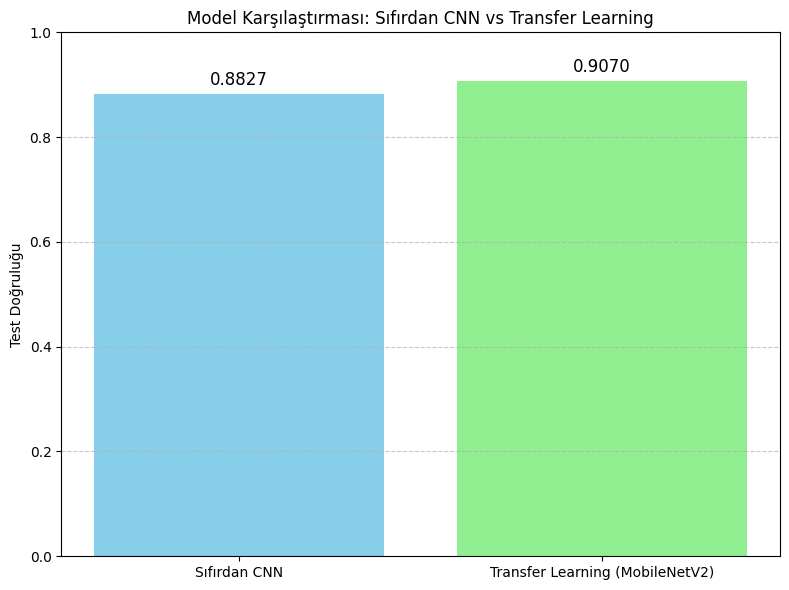

In [8]:
import matplotlib.pyplot as plt

# Eğer cnn_model test doğruluğu ayrı alınmadıysa:
# test_accuracy_cnn = cnn_model.evaluate(X_test, y_test_categorical, verbose=0)[1]

# Sadece son epoch'taki doğruluk kullanılıyorsa:
test_accuracy_cnn = history.history['val_accuracy'][-1]  # veya .evaluate(...) ile daha net alınabilir
test_accuracy_transfer = test_accuracy_transfer  # Zaten önceden alınmış

# Model adları ve doğruluklar
model_names = ['Sıfırdan CNN', 'Transfer Learning (MobileNetV2)']
accuracies = [test_accuracy_cnn, test_accuracy_transfer]

# Sütun grafiği
plt.figure(figsize=(8, 6))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'lightgreen'])

# Her bar üzerine noktadan sonra 4 hane olacak şekilde tam değerleri yazalım
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width() / 2,
             bar.get_height() + 0.01,
             f"{acc:.4f}",
             ha='center', va='bottom', fontsize=12)

plt.ylim(0, 1.0)
plt.ylabel('Test Doğruluğu')
plt.title('Model Karşılaştırması: Sıfırdan CNN vs Transfer Learning')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

Model Karşılaştırması: Sıfırdan CNN vs Transfer Learning

Bu bölümde, iki farklı yaklaşımın test verisi üzerindeki doğruluk performansları görsel olarak karşılaştırılmıştır:

Karşılaştırılan Modeller

Sıfırdan Eğitilen CNN Modeli
Transfer Learning (MobileNetV2)

Sonuç

Her iki modelin test doğrulukları bar grafik ile gösterilmiştir.


Adam optimizer ile eğitim...
Epoch 1/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 93s 351ms/step - accuracy: 0.5383 - loss: 1.3527 - val_accuracy: 0.1700 - val_loss: 6.7933
Epoch 2/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 69s 311ms/step - accuracy: 0.7173 - loss: 0.7920 - val_accuracy: 0.5880 - val_loss: 1.2900
Epoch 3/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 66s 297ms/step - accuracy: 0.7797 - loss: 0.6152 - val_accuracy: 0.7850 - val_loss: 0.5856
Epoch 4/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 65s 294ms/step - accuracy: 0.8066 - loss: 0.5364 - val_accuracy: 0.7960 - val_loss: 0.5666
Epoch 5/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 66s 299ms/step - accuracy: 0.8163 - loss: 0.5027 - val_accuracy: 0.8053 - val_loss: 0.5630
Epoch 6/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 65s 296ms/step - accuracy: 0.8319 - loss: 0.4765 - val_accuracy: 0.8083 - val_loss: 0.5811
Epoch 7/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 66s 300ms/step - accuracy: 0.8381 - loss: 0.4443 - val_accuracy: 0.7787 - val_loss: 0.6881
Epoch 8/10
220/220 ━━━━━━━━━━━━━━━━━━━━ 66s 298ms/ste

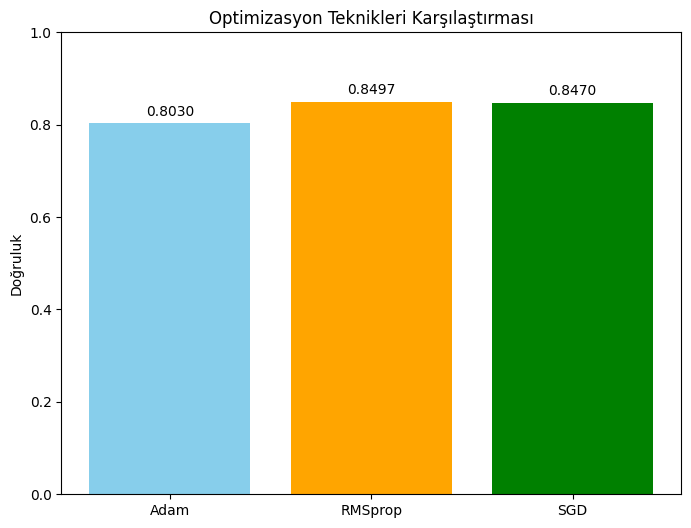

In [9]:
optimizers = {
    'Adam': keras.optimizers.Adam(learning_rate=0.001),
    'RMSprop': keras.optimizers.RMSprop(learning_rate=0.001),
    'SGD': keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
}

results = {}

for opt_name, optimizer in optimizers.items():
    print(f"\n{opt_name} optimizer ile eğitim...")

    model = create_optimized_cnn_model(input_shape=X_train.shape[1:], num_classes=num_classes)
    model.compile(optimizer=optimizer,
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    # datagen.fit(X_train) zaten yapılmış, eğitim için flow kullanıyoruz:
    history = model.fit(
        datagen.flow(X_train, y_train_categorical, batch_size=BATCH_SIZE),
        epochs=10,
        validation_data=(X_test, y_test_categorical),
        verbose=1
    )

    test_loss, test_acc = model.evaluate(X_test, y_test_categorical, verbose=0)
    results[opt_name] = test_acc
    print(f"{opt_name} Test Doğruluğu: {test_acc:.4f}")

# Sonuçları görselleştir
plt.figure(figsize=(8, 6))
bars = plt.bar(results.keys(), results.values(), color=['skyblue', 'orange', 'green'])
plt.title('Optimizasyon Teknikleri Karşılaştırması')
plt.ylabel('Doğruluk')
plt.ylim(0, 1)

for bar, accuracy in zip(bars, results.values()):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
             f'{accuracy:.4f}', ha='center', va='bottom')

plt.show()

Optimizasyon Yöntemleri Karşılaştırması

Bu kısımda, modelin eğitiminde kullanılan farklı optimizasyon algoritmalarının performansı karşılaştırılmıştır.

Denenen Optimizatörler:

Adam: Öğrenme hızı 0.001
RMSprop: Öğrenme hızı 0.001
SGD: Öğrenme hızı 0.01, momentum 0.9

İşlem:

Her optimizatör ile model ayrı ayrı oluşturulup eğitilmiştir (10 epoch).
Test verisi üzerinde doğruluklar ölçülüp kaydedilmiştir.

Sonuçların Görselleştirilmesi:

Optimizatörlere göre test doğrulukları bar grafik ile gösterilmiştir.
Sonuçlara baktığımızda en verimli SGD olurken ardından RMSprop ve Adam gelmektedir.

In [10]:
print("=" * 50)
print("Intel Image Classification Projesi")
print("=" * 50)
print(f"Temel CNN Model Doğruluğu: {test_accuracy:.4f}")
print(f"Transfer Learning Model Doğruluğu: {test_accuracy_transfer:.4f}")
print(f"En iyi optimizer: {max(results, key=results.get)} ({max(results.values()):.4f})")
print("=" * 50)

Intel Image Classification Projesi
Temel CNN Model Doğruluğu: 0.9053
Transfer Learning Model Doğruluğu: 0.9070
En iyi optimizer: RMSprop (0.8497)


Proje Özeti ve Sonuçlar

Bu bölümde, projenin temel başarı metrikleri ve önemli sonuçlar özetlenmiştir:

Temel CNN Modeli Test Doğruluğu:
Sıfırdan eğitilen CNN modelinin test setindeki başarısı.

Transfer Learning Modeli Test Doğruluğu:
Önceden eğitilmiş MobileNetV2 tabanlı modelin test başarısı.

En İyi Optimizatör:
Farklı optimizatörler arasında en yüksek test doğruluğunu sağlayan algoritma ve doğruluk değeri.